In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from matplotlib.patches import Polygon
from matplotlib.ticker import NullFormatter
from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 11 - Signal detection theory
  
The basic data for an SDT analysis are  the counts of hits, false alarms, misses, and correct rejections. It is common to consider just the hit and false alarm counts which, together with the total number of signal and noise trials, completely describe the data.

|                  |   Signal trial   |   Noise trial    |
|:----------------:|:----------------:|:----------------:|
| Yes response     |        Hit       |   False alarm    |
| No response      |       Miss       |Correct rejection | 

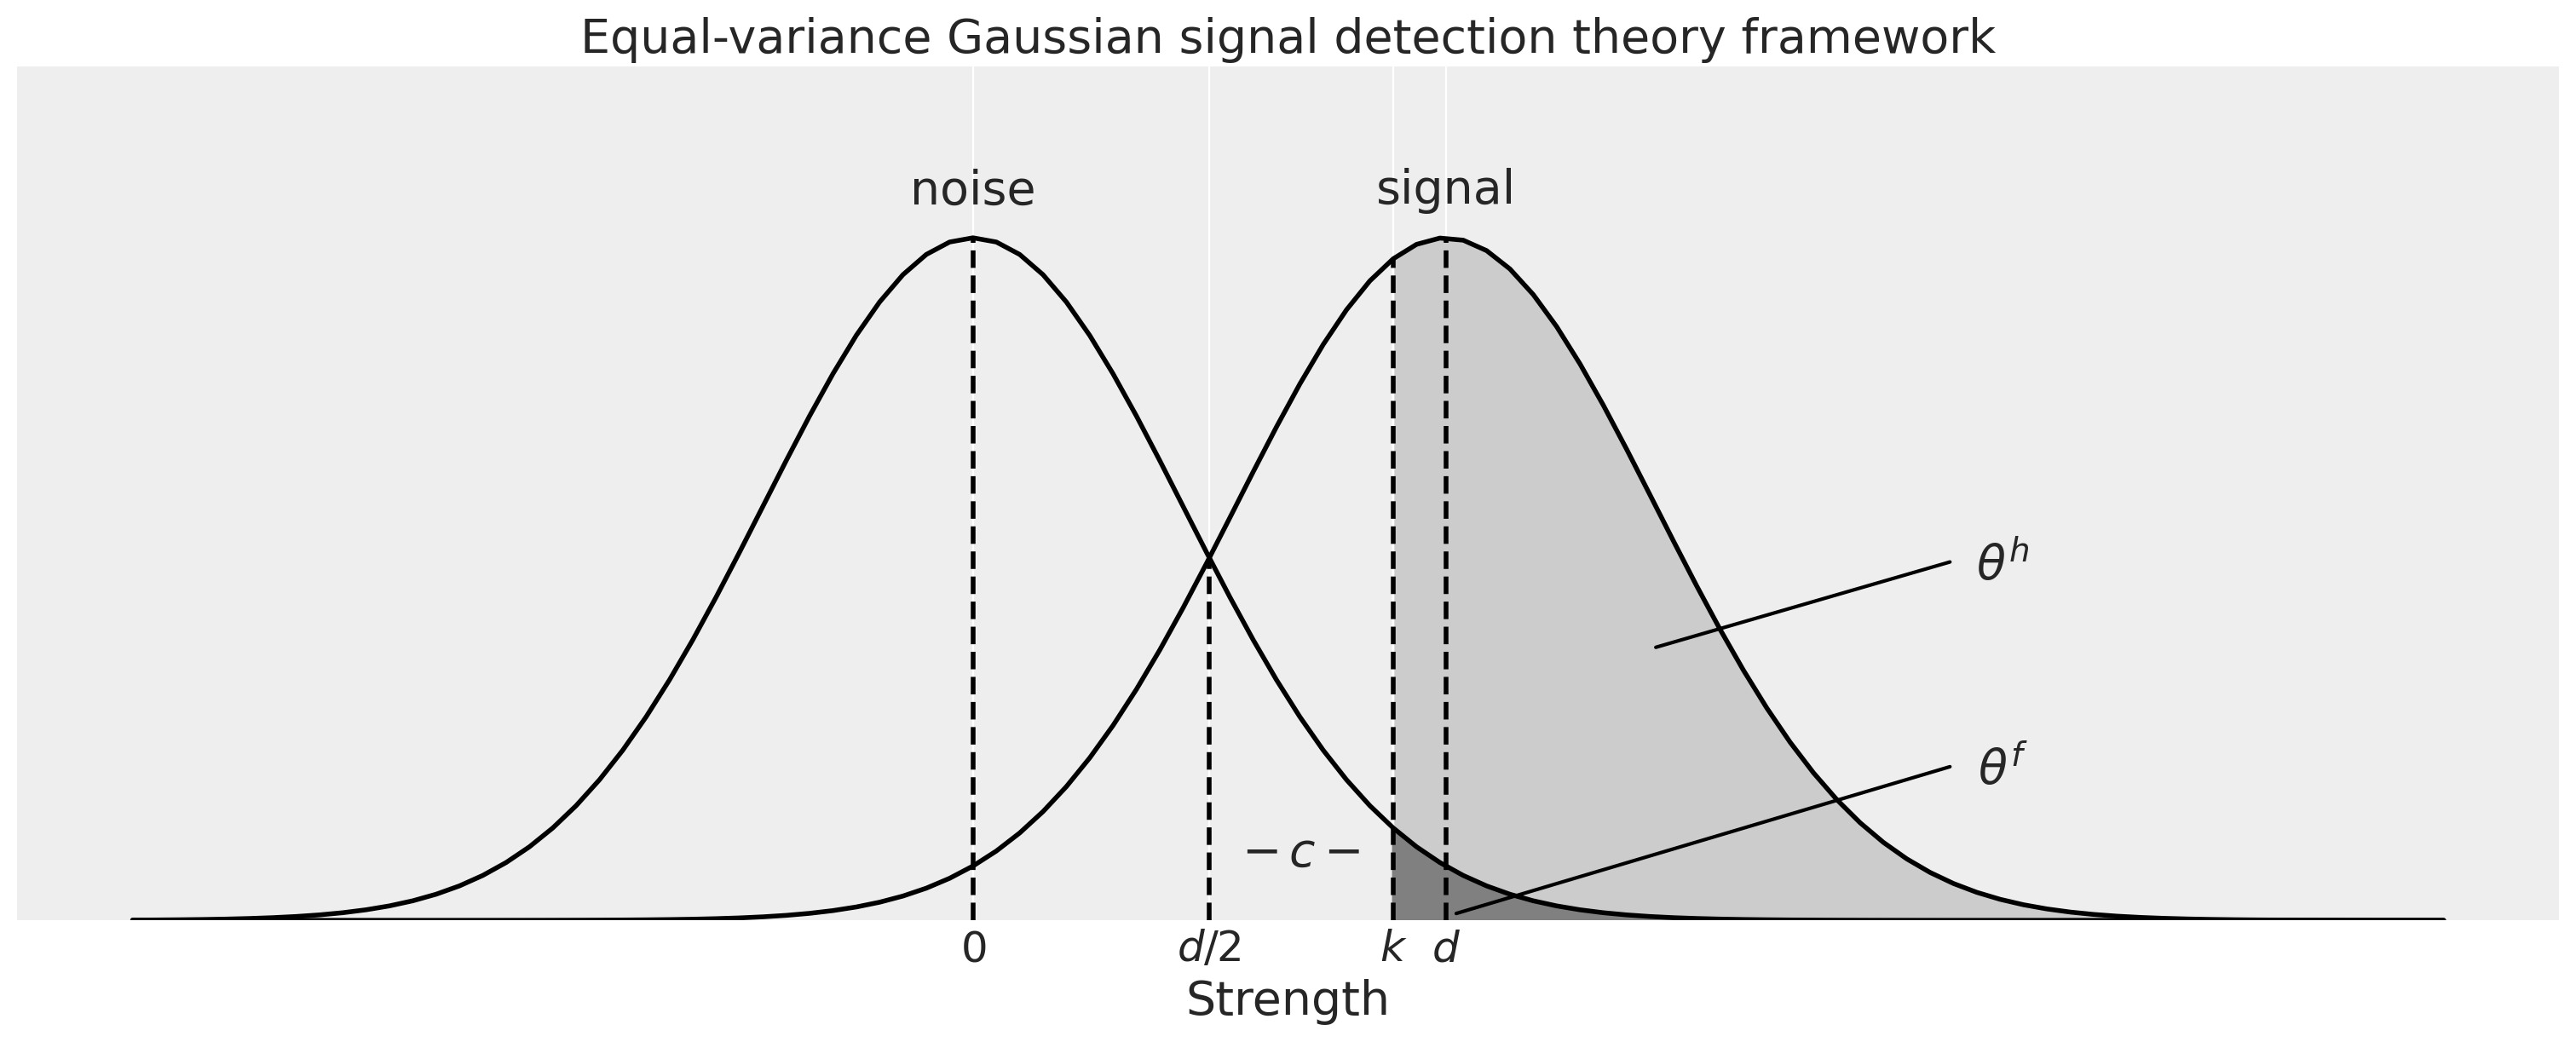

In [3]:
func = stats.norm.pdf

a, b, d = 2, 7, 2.25  # integral limits 1
x = np.linspace(-4, b, 100)
y = func(x)
y2 = func(x, loc=d)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(x, y, "k", linewidth=2)
plt.plot(x, y2, "k", linewidth=2)
d2 = x[y == y2]

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
iy2 = func(ix, loc=d)

verts = [(a, 0)] + list(zip(ix, iy2)) + [(b, 0)]
poly = Polygon(verts, facecolor=".8", edgecolor="1")
ax.add_patch(poly)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor=".5", edgecolor="0.5")
ax.add_patch(poly)

plt.text(0, y.max() + 0.02, "noise", horizontalalignment="center", fontsize=20)
plt.text(d, y.max() + 0.02, "signal", horizontalalignment="center", fontsize=20)
plt.text(
    (d / 2 + a) / 2,
    y.max() * 0.08,
    r"$ - \,c - $",
    horizontalalignment="center",
    fontsize=20,
)
plt.text(
    b * 0.7, y.max() * 0.5, r"$\theta^h$", horizontalalignment="center", fontsize=20
)
plt.text(
    b * 0.7, y.max() * 0.2, r"$\theta^f$", horizontalalignment="center", fontsize=20
)
plt.plot(
    [d + 1, b * 0.7 - 0.25],
    [y.max() * 0.4, y.max() * 0.5 + 0.01],
    color="k",
    linestyle="-",
    linewidth=1.5,
)
plt.plot(
    [d + 0.05, b * 0.7 - 0.25],
    [y.max() * 0.01, y.max() * 0.2 + 0.01],
    color="k",
    linestyle="-",
    linewidth=1.5,
)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position("bottom")

plt.plot([0, 0], [0, func(0)], color="k", linestyle="--", linewidth=2)
plt.plot([d / 2, d / 2], [0, func(d / 2)], color="k", linestyle="--", linewidth=2)
plt.plot([a, a], [0, func(a, loc=d)], color="k", linestyle="--", linewidth=2)
plt.plot([d, d], [0, func(d, loc=d)], color="k", linestyle="--", linewidth=2)

ax.set_xticks((0, a, d, d / 2))
ax.set_xticklabels(("$0$", "$k$", "$d$", "$d/2$"), fontsize=18)
ax.set_yticks([])
plt.ylim(0, y.max() + 0.1)
plt.title("Equal-variance Gaussian signal detection theory framework", fontsize=20)
plt.xlabel("Strength", fontsize=20);

## 11.1 Signal detection theory


$$ d_{i} \sim \text{Gaussian}(0,\frac{1}{2})$$
$$ c_{i} \sim \text{Gaussian}(0,2)$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [4]:
#  Load data
dataset = 1
if dataset == 1:  # Demo
    k = 3  # number of cases
    data = np.array([70, 50, 30, 50, 7, 5, 3, 5, 10, 0, 0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data
    k = 3  # number of cases
    data = np.array([148, 29, 32, 151, 150, 40, 30, 140, 150, 51, 40, 139]).reshape(
        k, -1
    )

h = data[:, 0]
f = data[:, 1]
MI = data[:, 2]
CR = data[:, 3]
s = h + MI
n = f + CR

In [5]:
def Phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    # Also it is the probit transform
    return 0.5 + 0.5 * pm.math.erf(x / pm.math.sqrt(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bias, Discriminability]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


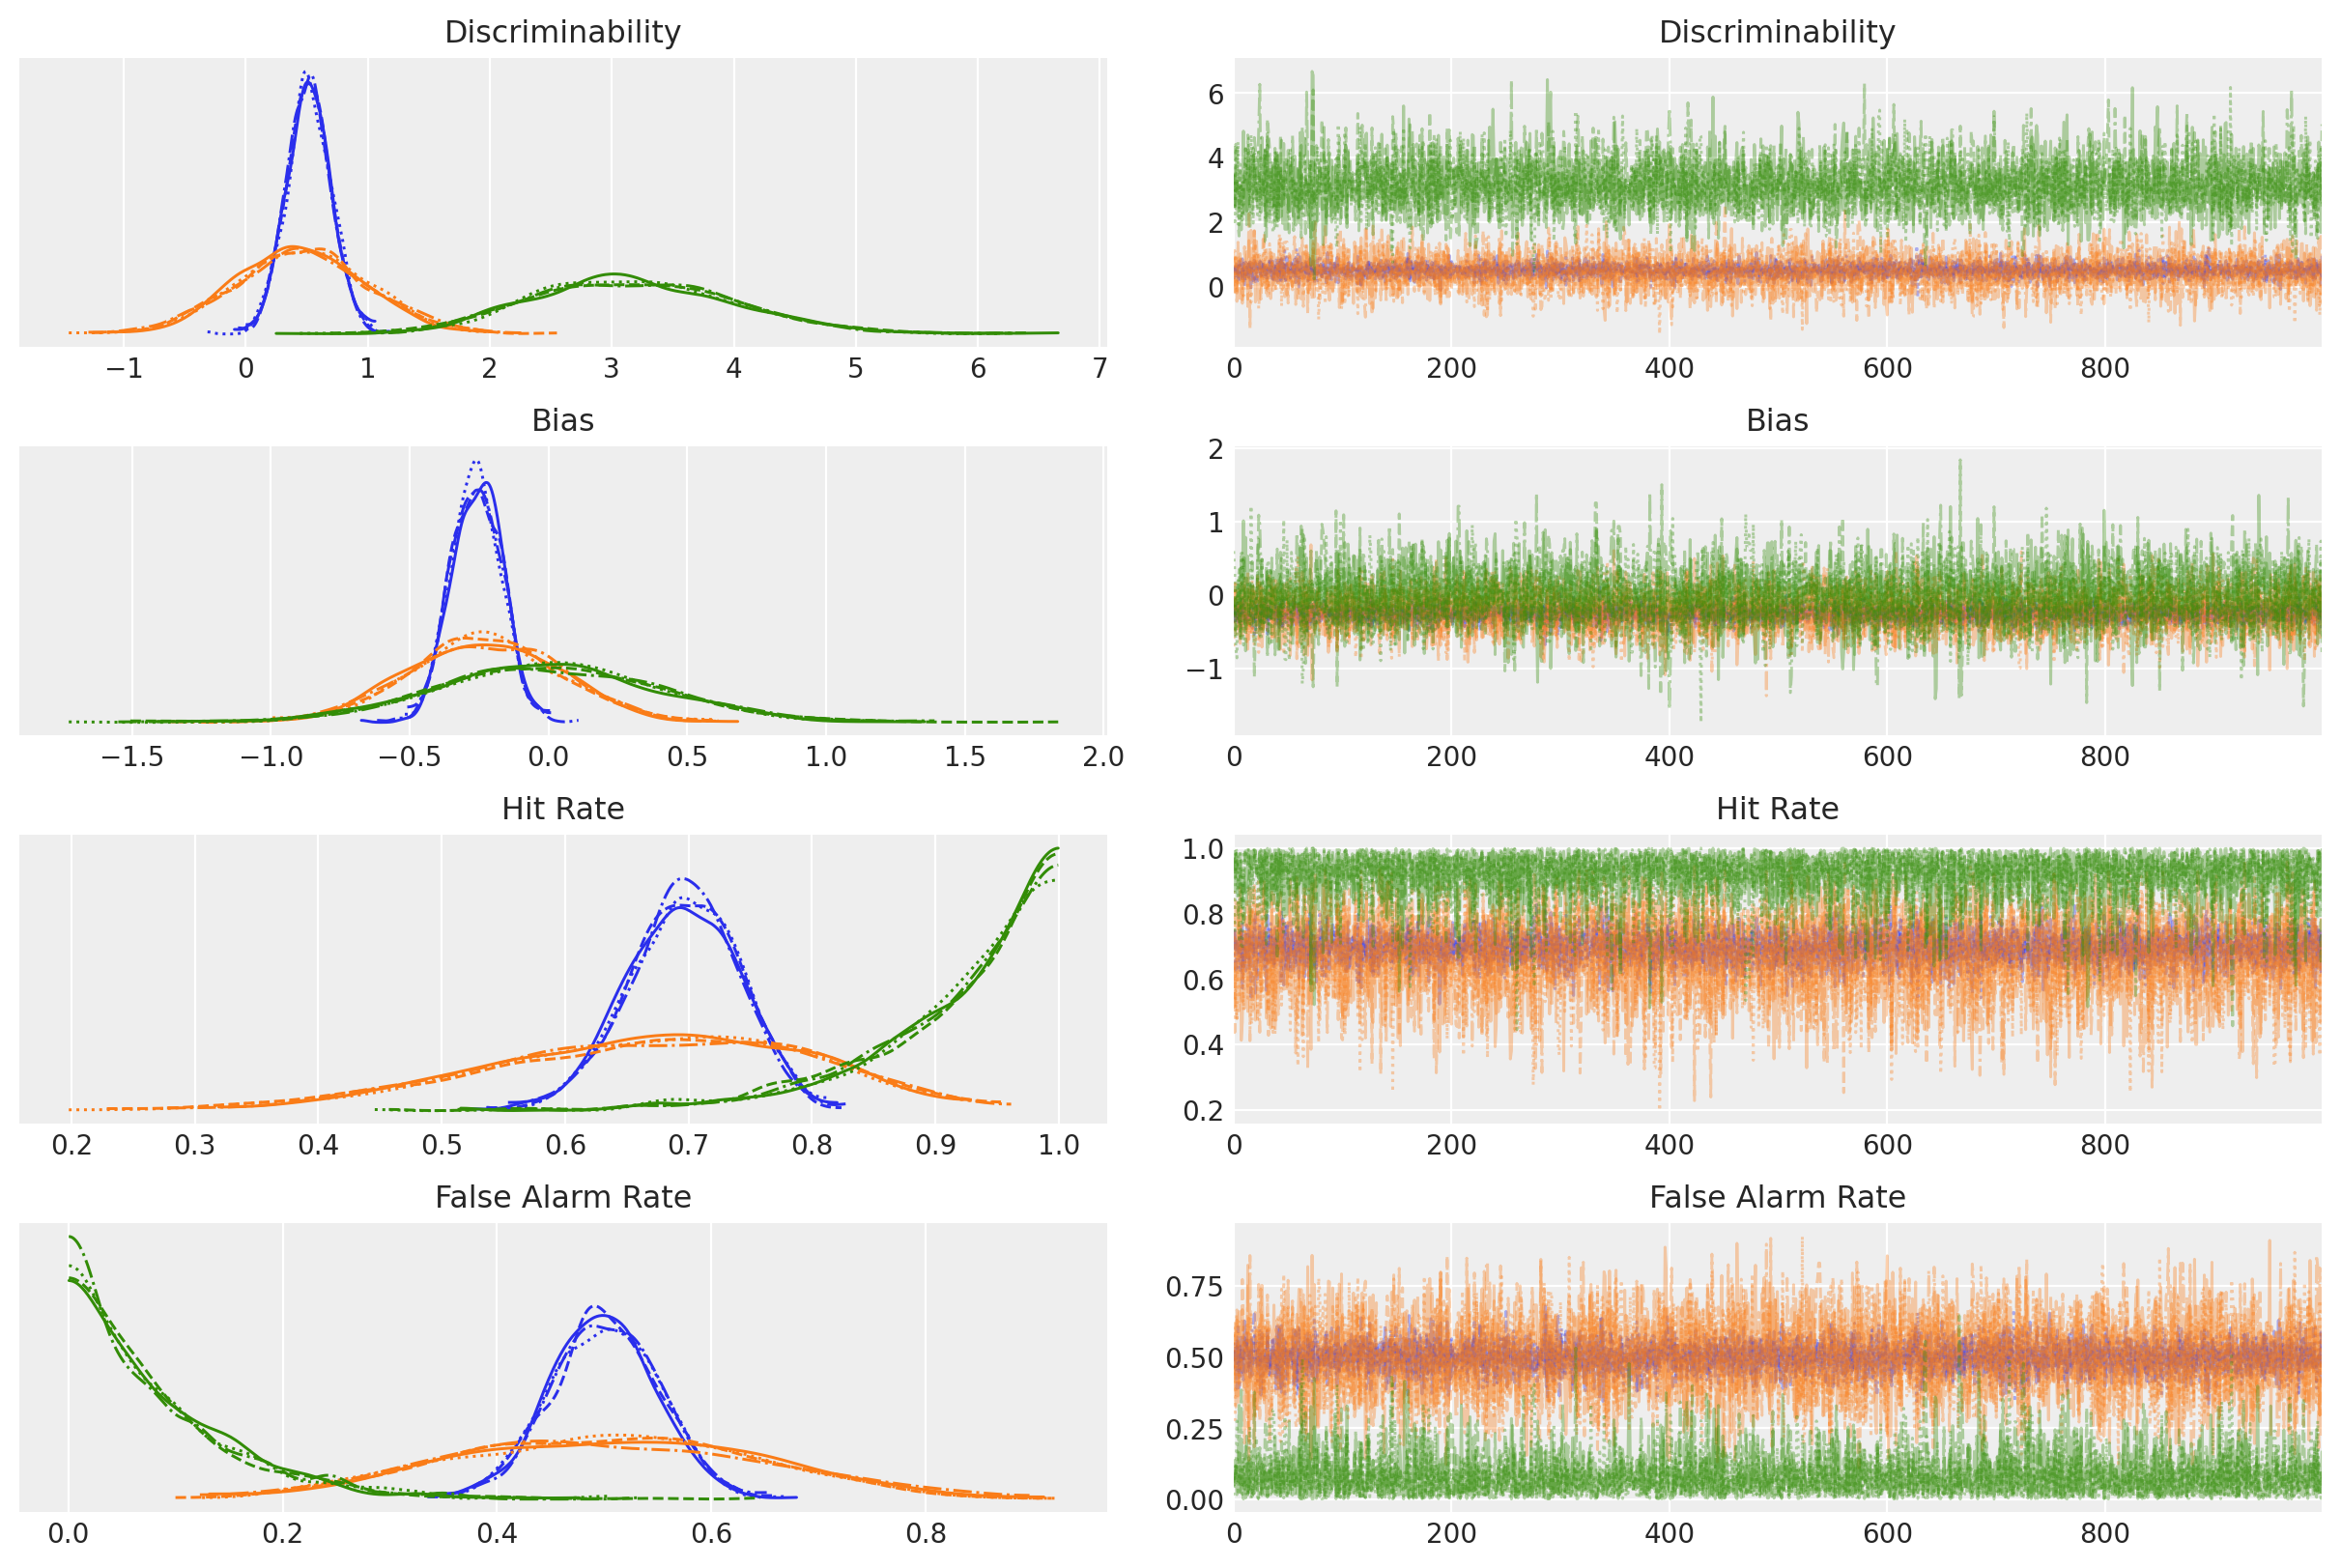

In [6]:
with pm.Model() as model1:
    di = pm.Normal("Discriminability", mu=0, tau=0.5, shape=k)
    ci = pm.Normal("Bias", mu=0, tau=2, shape=k)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s, observed=h)
    fi = pm.Binomial("fi", p=thetaf, n=n, observed=f)
    trace1 = pm.sample()

az.plot_trace(
    trace1, var_names=["Discriminability", "Bias", "Hit Rate", "False Alarm Rate"], compact=True
);

## 11.2 Hierarchical signal detection theory
  
$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ d_{i} \sim \text{Gaussian}(\mu_{d},\lambda_{d})$$
$$ c_{i} \sim \text{Gaussian}(\mu_{c},\lambda_{c})$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [7]:
std_d = pd.read_csv("data/heit_rotello_std_d.csv") # deduction data
std_i = pd.read_csv("data/heit_rotello_std_i.csv") # induction data

In [8]:
h1  = np.array(std_i['V1'])
f1  = np.array(std_i['V2'])
MI1 = np.array(std_i['V3'])
CR1 = np.array(std_i['V4'])
s1 = h1 + MI1
n1 = f1 + CR1

h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k = len(h1)

In [9]:
with pm.Model() as model2i:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s1, observed=h1)
    fi = pm.Binomial("fi", p=thetaf, n=n1, observed=f1)
    
    trace_i = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ci, di, lambdac, lambdad, muc, mud]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [10]:
with pm.Model() as model2d:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s2, observed=h2)
    fi = pm.Binomial("fi", p=thetaf, n=n2, observed=f2)
    
    trace_d = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ci, di, lambdac, lambdad, muc, mud]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


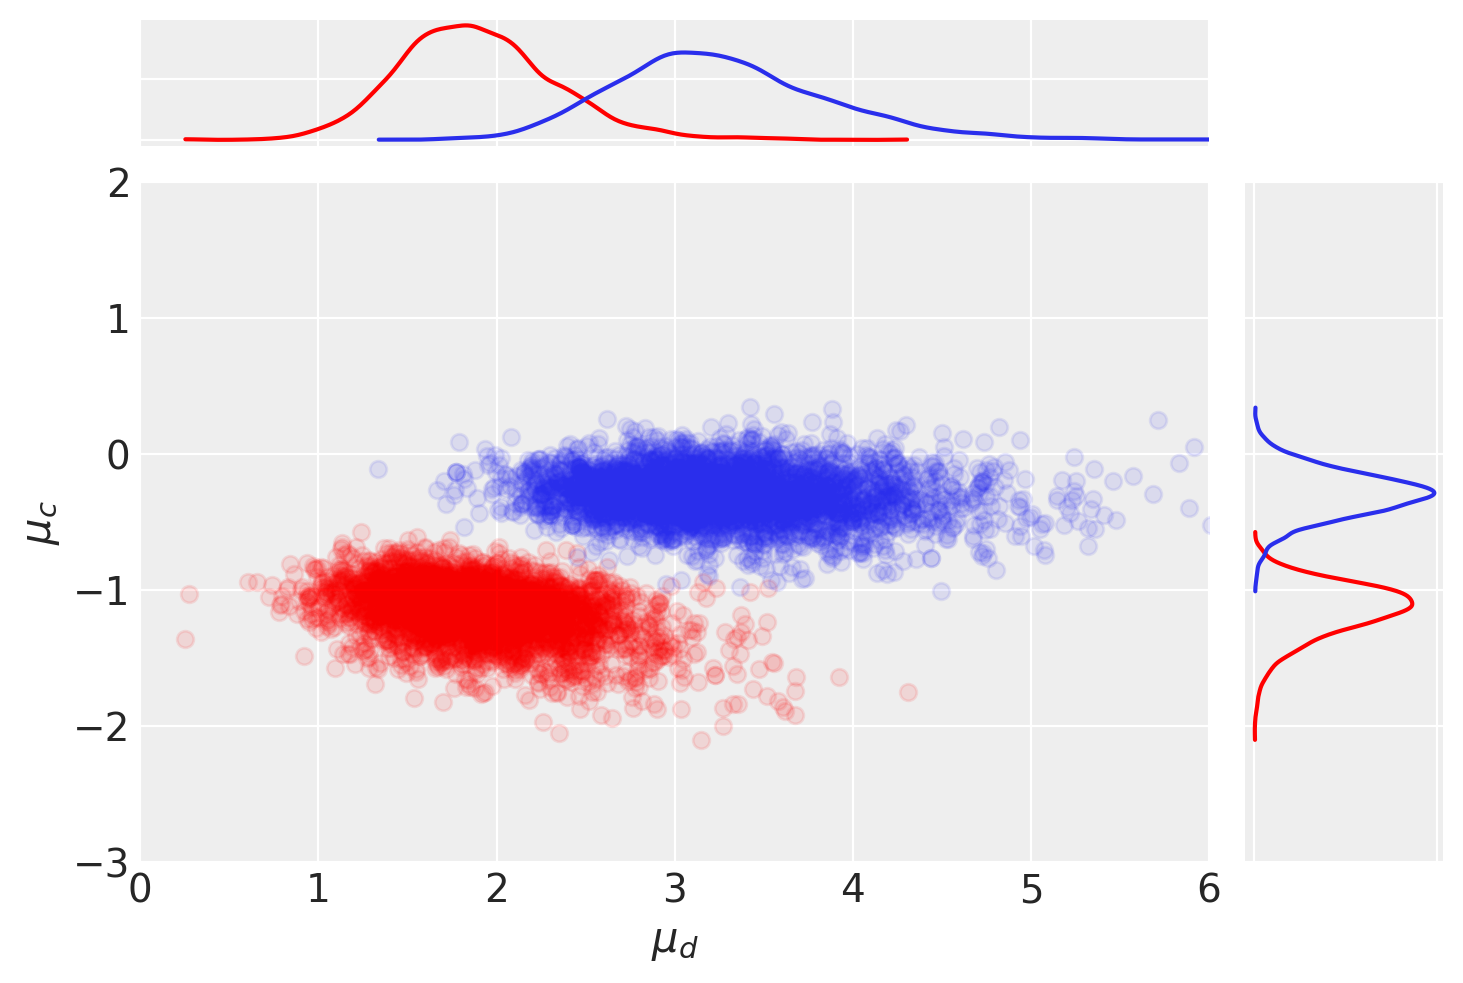

In [11]:
axes = az.plot_joint(trace_i, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1, "color": "red"}, marginal_kwargs={"color": "r"})
az.plot_joint(trace_d, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1}, ax=axes)
axes[0].set_xlim((0, 6))
axes[0].set_ylim((-3, 2))
axes[0].set_xlabel(r"$\mu_d$")
axes[0].set_ylabel(r"$\mu_c$");

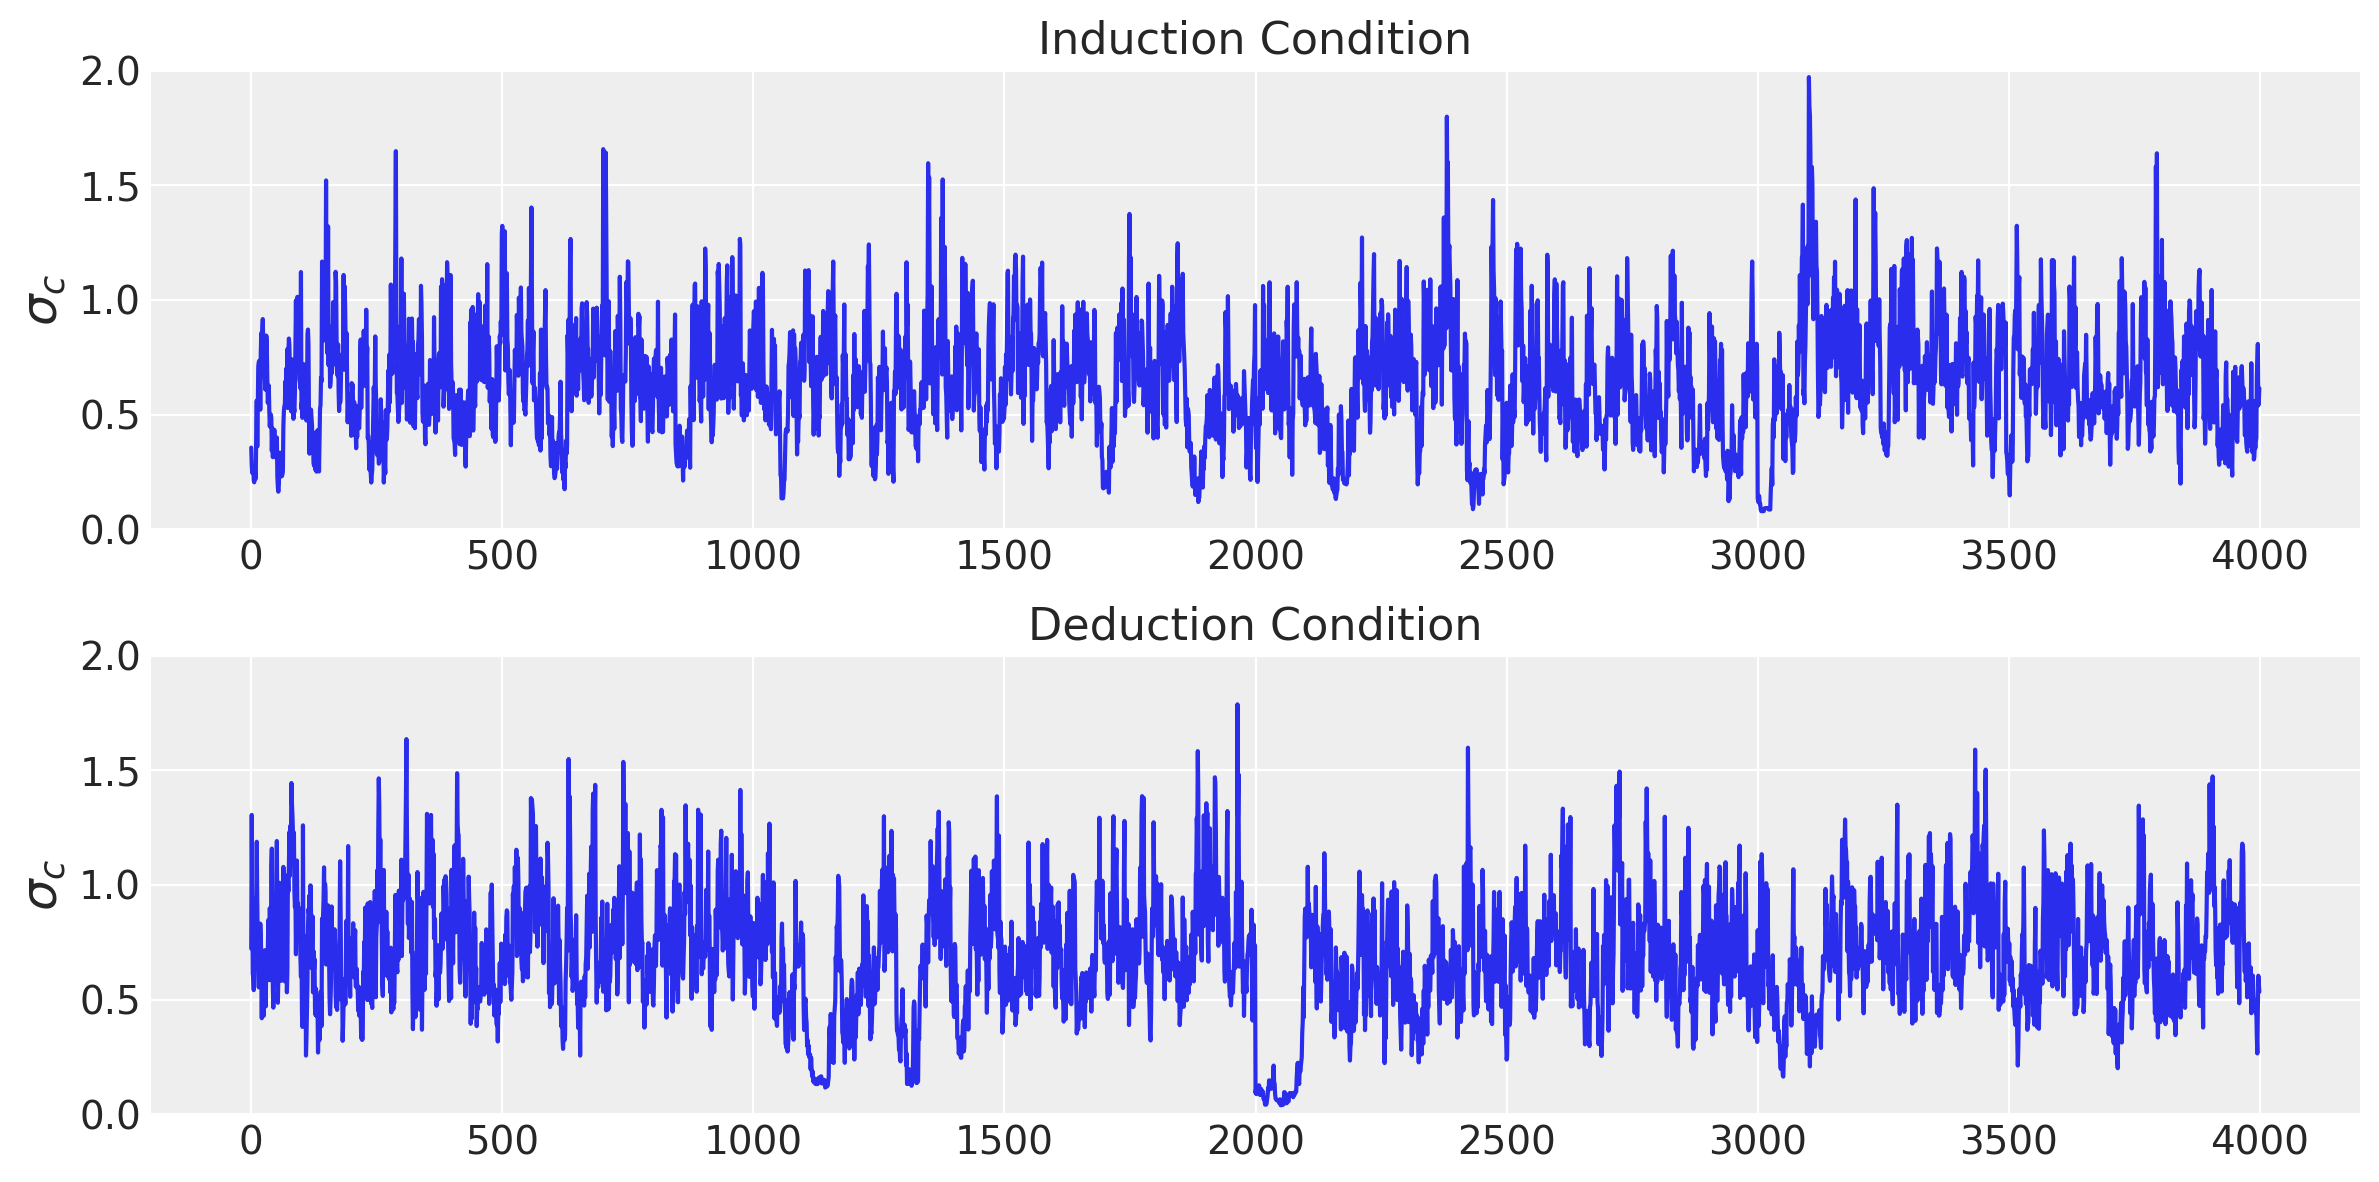

In [12]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))
tmptrace = trace_i["lambdac"]
ax[0].plot(1 / np.sqrt(tmptrace))
ax[0].set_ylim(0, 2)
ax[0].set_title("Induction Condition")
ax[0].set_ylabel(r"$\sigma_c$", fontsize=18)

tmptrace = trace_d["lambdac"]
ax[1].plot(1 / np.sqrt(tmptrace))
ax[1].set_ylim(0, 2)
ax[1].set_title("Deduction Condition")
ax[1].set_ylabel(r"$\sigma_c$", fontsize=18)

plt.tight_layout();

## 11.3 Parameter expansion
  
  
Using parameter expansion to escape the "zero variance trap" in MCMC sampling.  

$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ \xi_{d},\xi_{c} \sim \text{Beta}(1,1)$$
$$ \delta_{d_{i}} \sim \text{Gaussian}(0,\lambda_{d})$$
$$ \delta_{c_{i}} \sim \text{Gaussian}(0,\lambda_{c})$$
$$ \sigma_{d} = \lvert \xi_{d}\rvert\,/\,\sqrt\lambda_{d}$$
$$ \sigma_{c} = \lvert \xi_{c}\rvert\,/\,\sqrt\lambda_{c}$$
$$ d_{i} = \mu_{d} + \xi_{d}\delta_{d_{i}}$$
$$ c_{i} = \mu_{c} + \xi_{c}\delta_{c_{i}}$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [14]:
with pm.Model() as model3i:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)
    xid = pm.Uniform("xid", lower=0, upper=1)
    xic = pm.Uniform("xic", lower=0, upper=1)
    deltadi = pm.Normal("deltadi", mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal("deltaci", mu=0, tau=lambdac, shape=k)

    sigmad = pm.Deterministic("sigmad", xid / tt.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac", xic / tt.sqrt(lambdac))

    di = pm.Deterministic("di", mud + xid * deltadi)
    ci = pm.Deterministic("ci", muc + xic * deltaci)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s1, observed=h1)
    fi = pm.Binomial("fi", p=thetaf, n=n1, observed=f1)
    
    trace_i2 = pm.sample(tune=4000, target_accept=0.99)

with pm.Model() as model3d:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)
    xid = pm.Uniform("xid", lower=0, upper=1)
    xic = pm.Uniform("xic", lower=0, upper=1)
    deltadi = pm.Normal("deltadi", mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal("deltaci", mu=0, tau=lambdac, shape=k)

    sigmad = pm.Deterministic("sigmad", xid / tt.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac", xic / tt.sqrt(lambdac))

    di = pm.Deterministic("di", mud + xid * deltadi)
    ci = pm.Deterministic("ci", muc + xic * deltaci)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s2, observed=h2)
    fi = pm.Binomial("fi", p=thetaf, n=n2, observed=f2)
    
    trace_d2 = pm.sample(tune=4000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [deltaci, deltadi, xic, xid, lambdac, lambdad, muc, mud]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 359 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [deltaci, deltadi, xic, xid, lambdac, lambdad, muc, mud]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 277 seconds.
The acceptance probability does not match the target. It is 0.9359408372187543, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


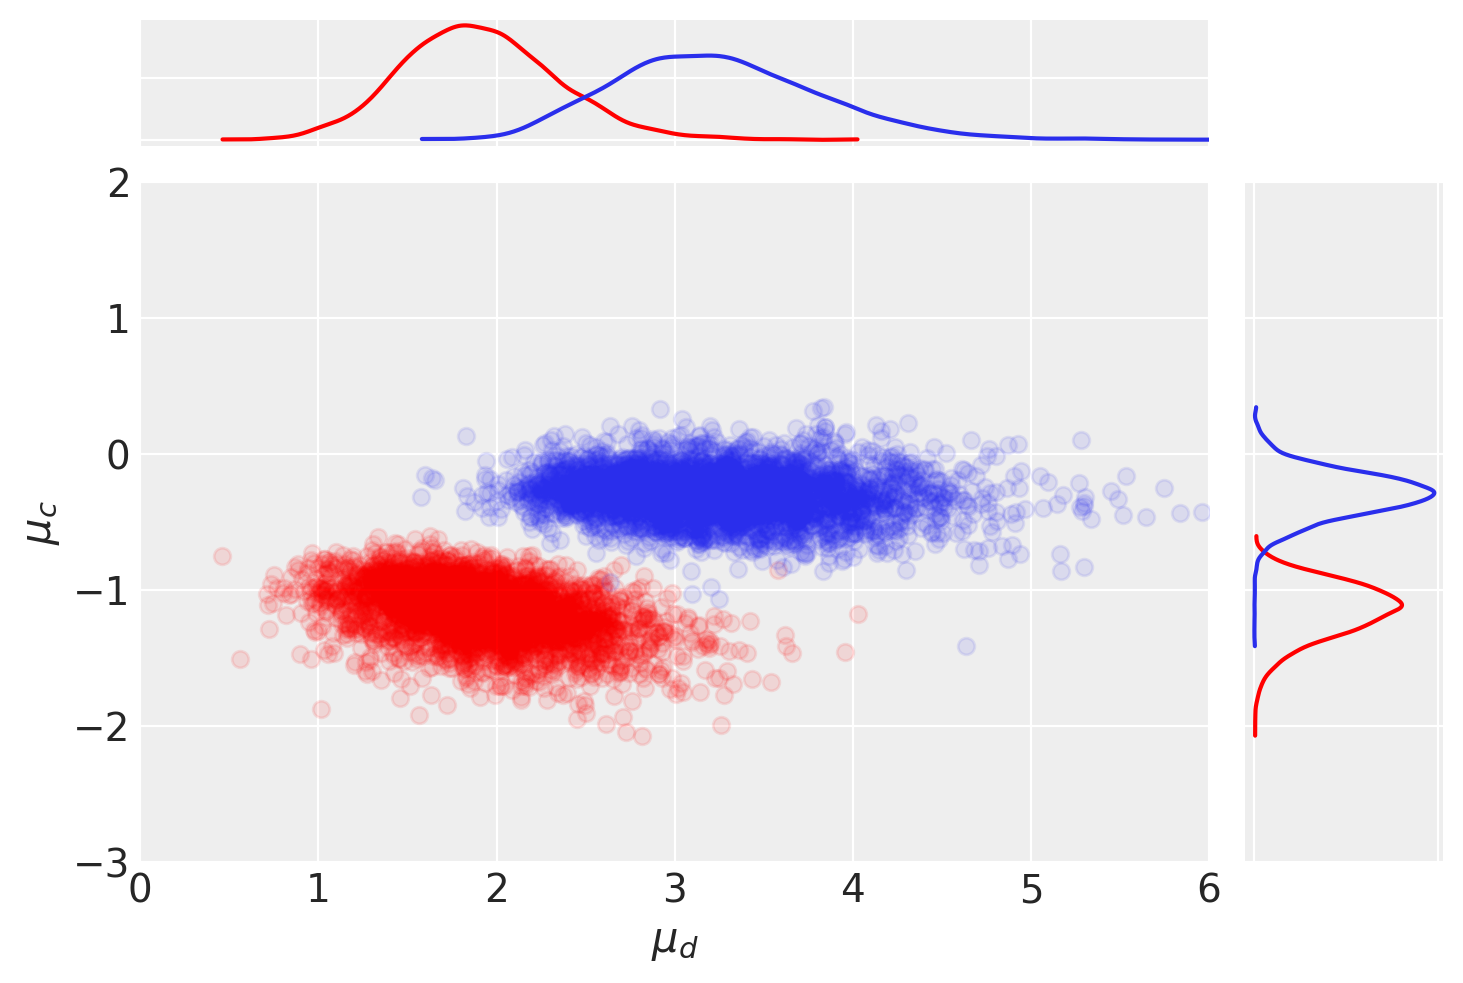

In [15]:
axes = az.plot_joint(trace_i2, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1, "color": "red"}, marginal_kwargs={"color": "r"})
az.plot_joint(trace_d2, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1}, ax=axes)
axes[0].set_xlim((0, 6))
axes[0].set_ylim((-3, 2))
axes[0].set_xlabel(r"$\mu_d$")
axes[0].set_ylabel(r"$\mu_c$");

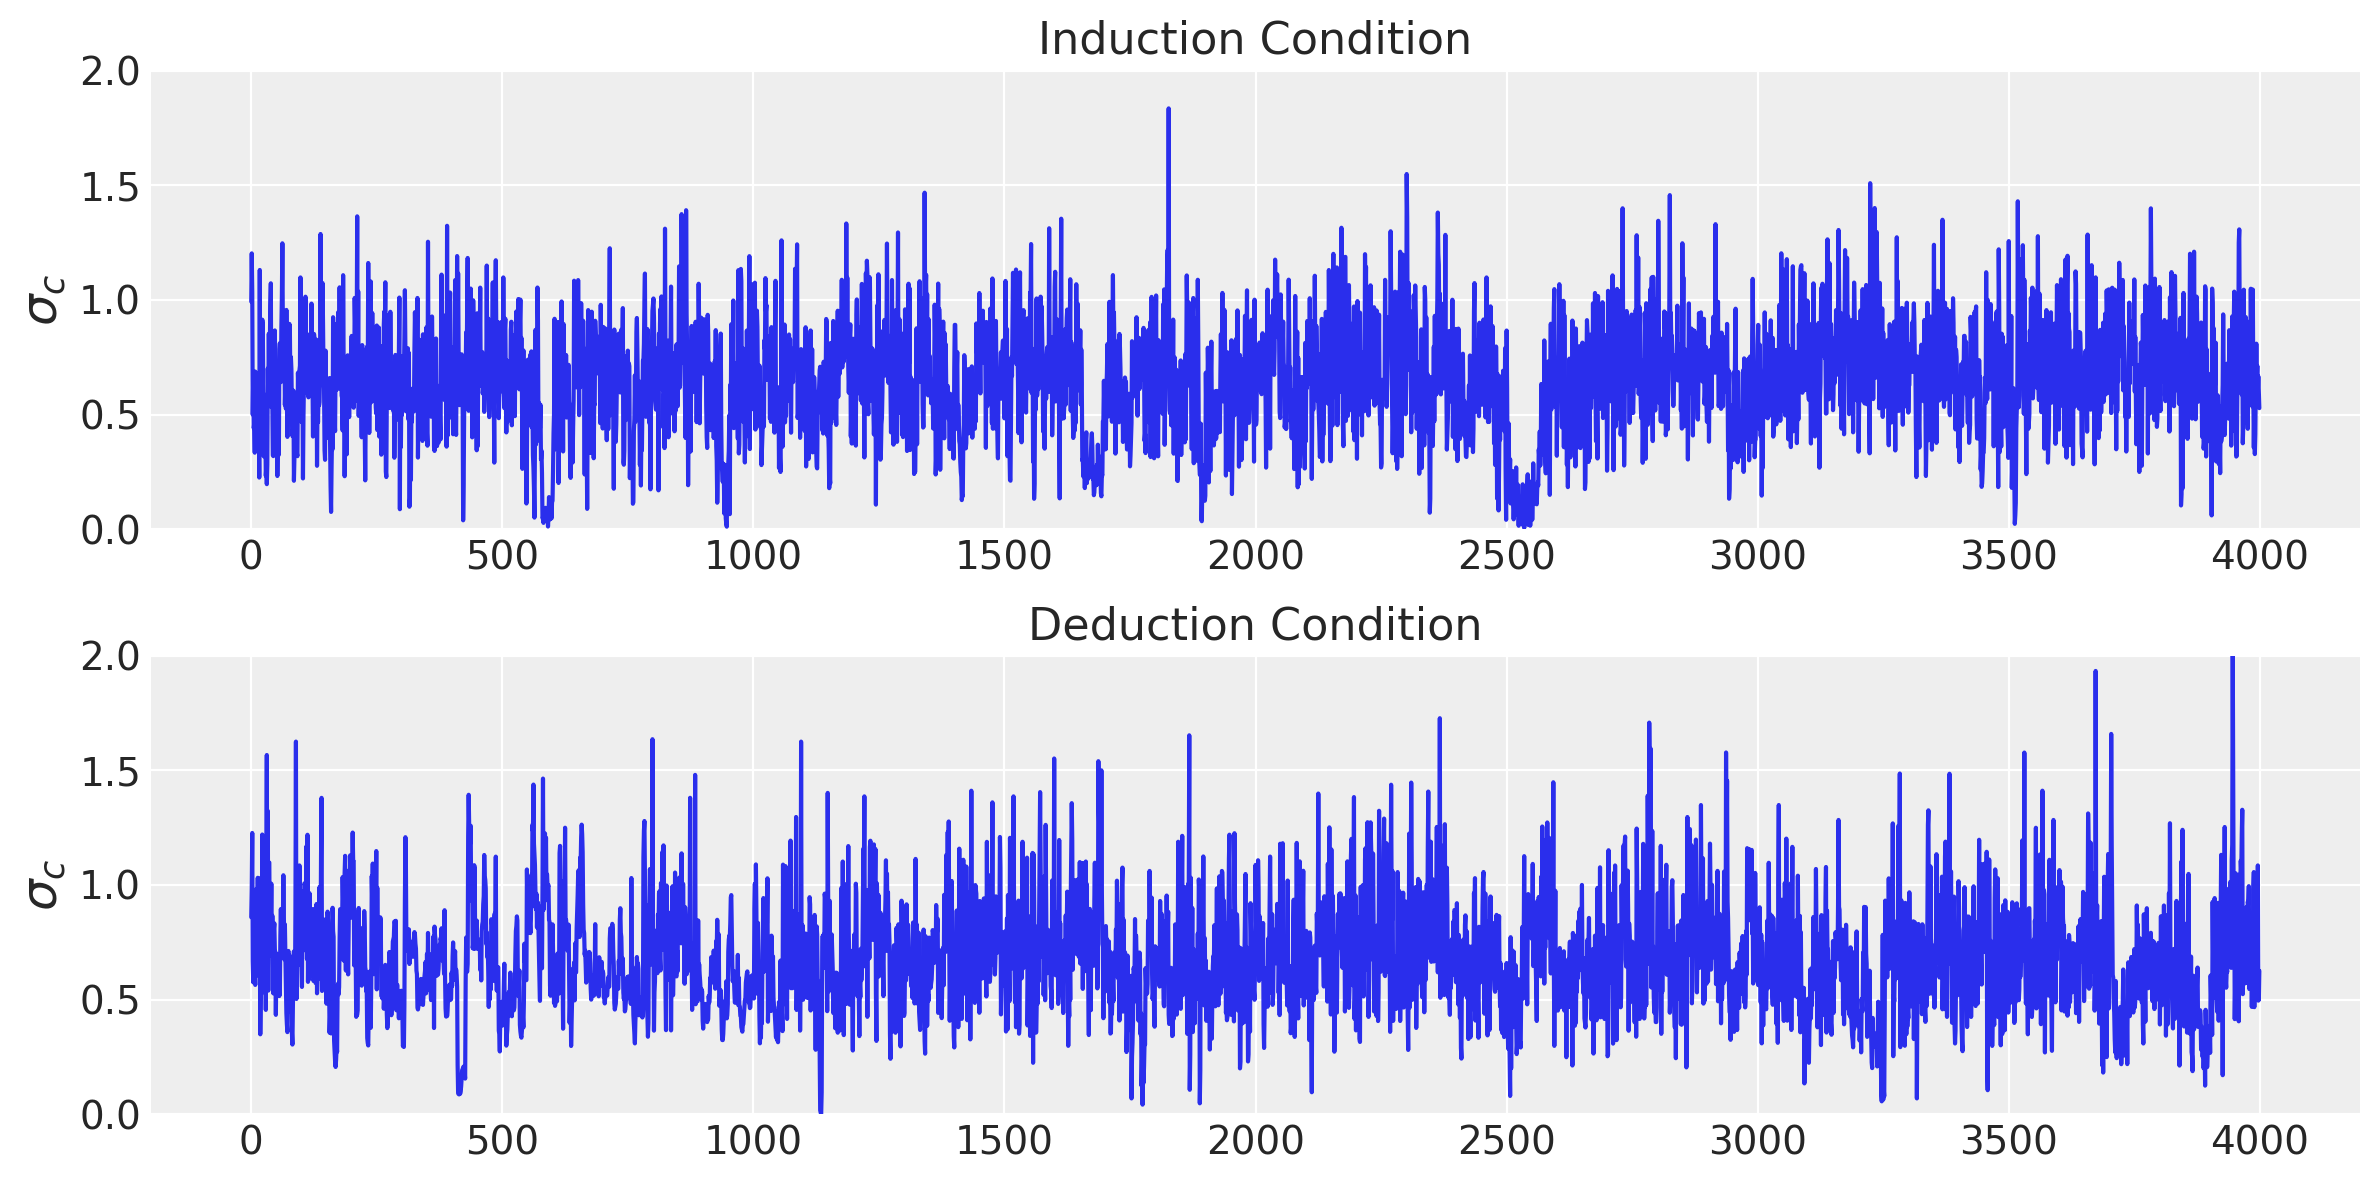

In [16]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(trace_i2["sigmac"])
ax[0].set_ylim(0, 2)
ax[0].set_title("Induction Condition")
ax[0].set_ylabel(r"$\sigma_c$", fontsize=18)

ax[1].plot(trace_d2["sigmac"])
ax[1].set_ylim(0, 2)
ax[1].set_title("Deduction Condition")
ax[1].set_ylabel(r"$\sigma_c$", fontsize=18)

plt.tight_layout();

### Note from Junpeng Lao
Sampling using HMC (e.g., in STAN and PyMC), there are better way to diagnose biased inference [[1]](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html), [[2]](http://pymc-devs.github.io/pymc/notebooks/Diagnosing_biased_Inference_with_Divergences.html).

In [19]:
def plot_samplerstat(trace, burnin=0):
    # Sampler statistics
    accept = trace.get_sampler_stats("mean_tree_accept", burn=burnin)
    
    print("The accept rate is: %.5f" % (accept.mean()))
    diverge = trace.get_sampler_stats("diverging")
    print("Divergences of the trace:")
    print(diverge.nonzero())
    
    az.plot_energy(trace)

The accept rate is: 0.94542
Divergences of the trace:
(array([2433, 3007, 3010, 3011, 3015, 3017, 3019, 3021]),)


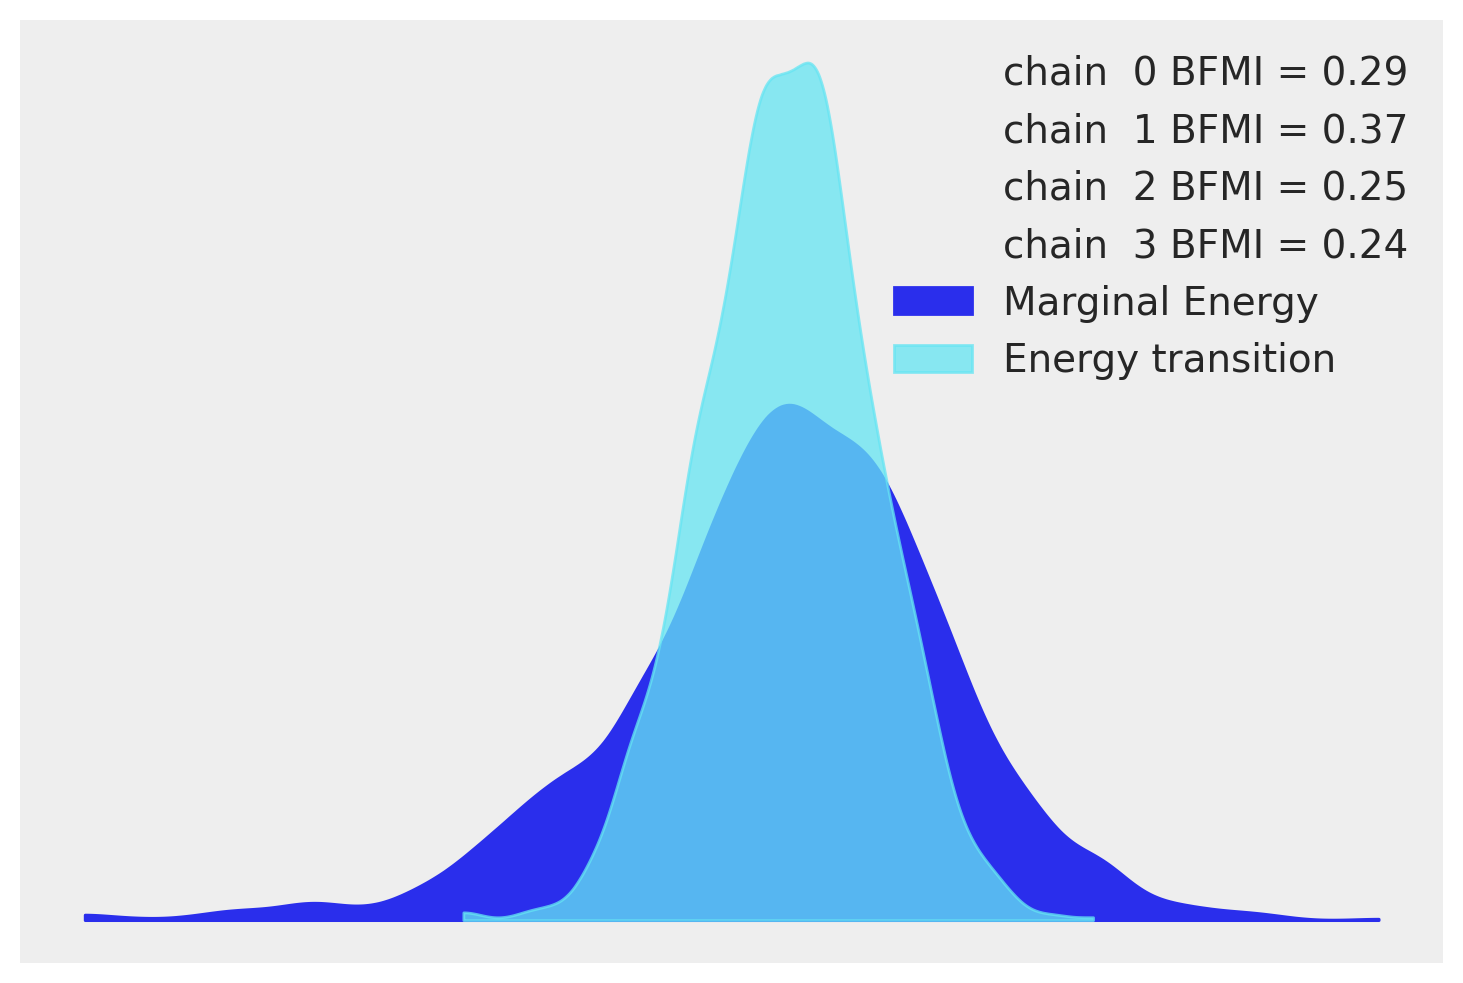

In [20]:
plot_samplerstat(trace_i)

The accept rate is: 0.94020
Divergences of the trace:
(array([2023, 2054]),)


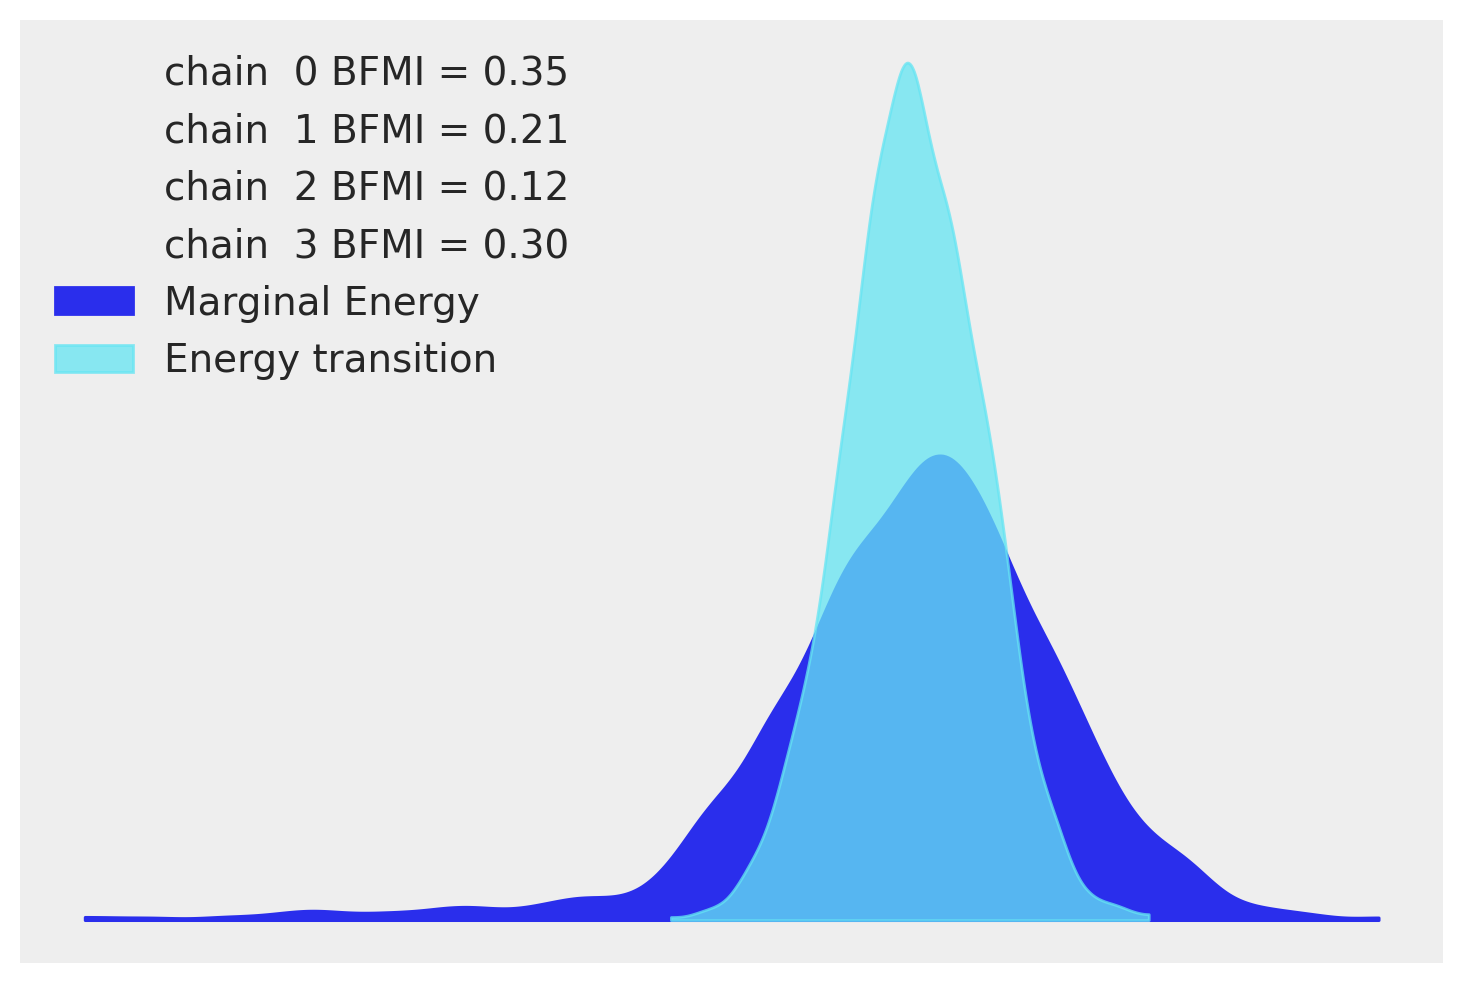

In [21]:
plot_samplerstat(trace_d)

The accept rate is: 0.98937
Divergences of the trace:
(array([], dtype=int64),)


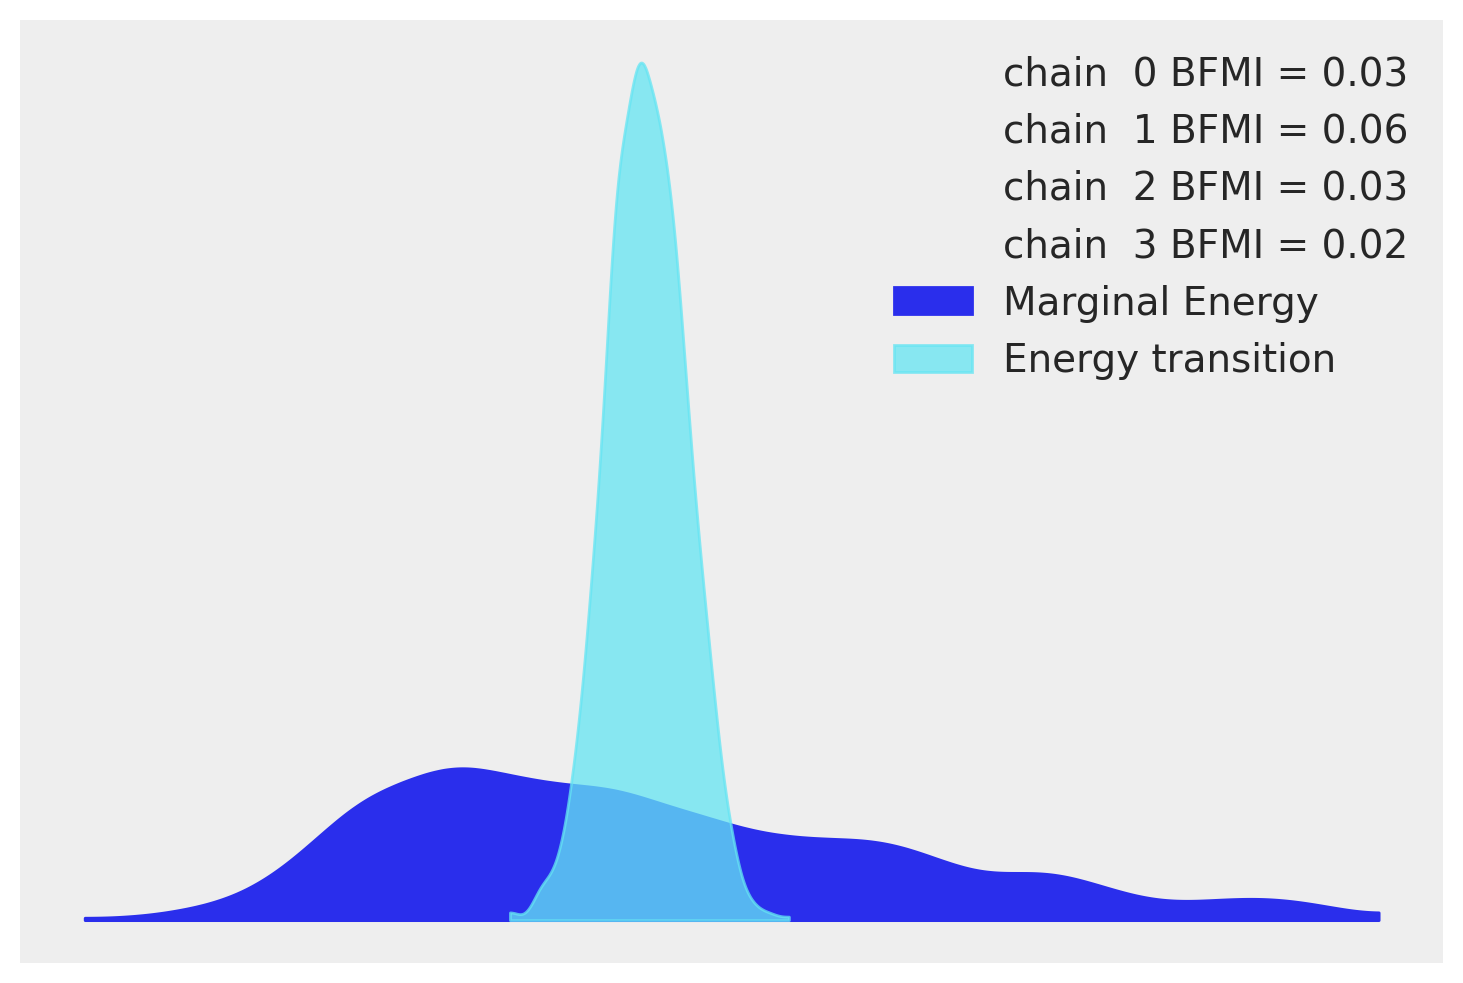

In [22]:
plot_samplerstat(trace_i2)

The accept rate is: 0.97722
Divergences of the trace:
(array([], dtype=int64),)


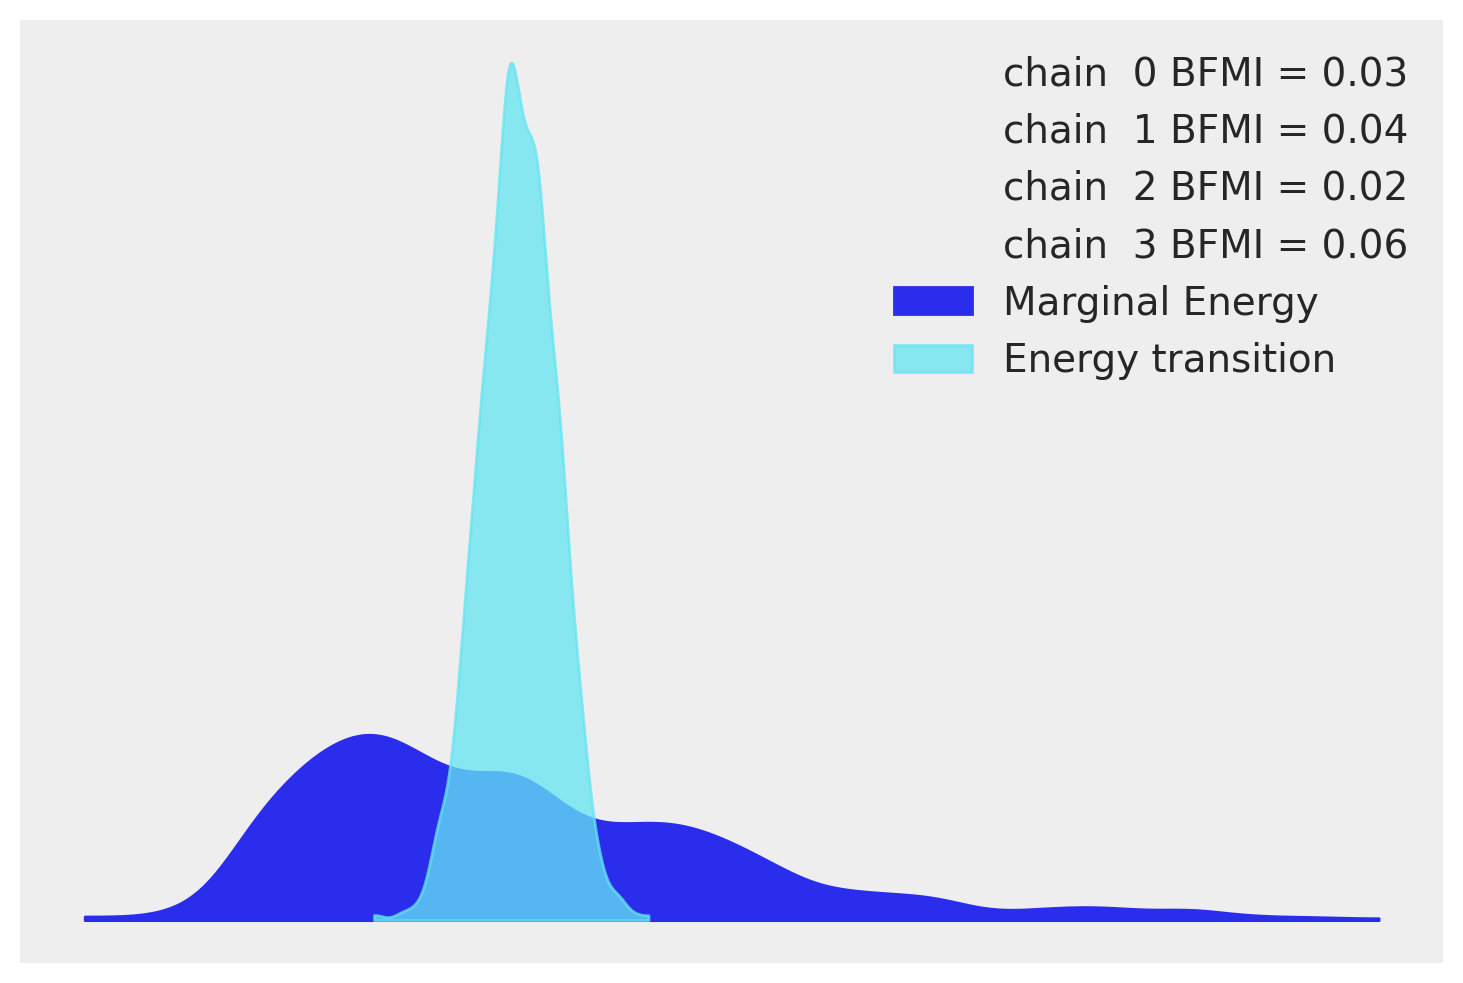

In [23]:
plot_samplerstat(trace_d2)

As shown above, there are a lot of divergences in the trace, and the energy plot is very different from the energy_diff. This is a strong indication of bias in the estimation, and better reparameterization is needed.

Moreover, the reparameterization, which works better in BUGS/JAGS using Gibbs sampler, actually perform worse using NUTS. Again, this demonstrates that many of the tricks and intuition we got using BUGS/JAGS might not translate to PyMC and STAN.

### Note from Ricardo Vieira
The reparametrization mentioned in the book is very different than the one usually recommended for normal prior parameters in hierarchical models (e.g., in [Stan User's Guide](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html)), where $x \sim normal(mu, sigma)$ is replaced by $x \sim mu + sigma \cdot normal(0, 1)$. This might explain why this model is not performing much better. Using the more conventional reparameterization the sampling diagnostics (and speed) improve largely.

In [24]:
with pm.Model() as model4i:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    deltadi = pm.Normal('deltadi', mu=0, sigma=1, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, sigma=1, shape=k)

    sigmad = pm.Deterministic("sigmad", 1 / tt.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac", 1 / tt.sqrt(lambdac))

    di = pm.Deterministic("di", mud + deltadi / tt.sqrt(lambdad))
    ci = pm.Deterministic("ci", muc + deltaci / tt.sqrt(lambdac))

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s1, observed=h1)
    fi = pm.Binomial("fi", p=thetaf, n=n1, observed=f1)
    
    trace_i3 = pm.sample(tune=4000, target_accept=0.99)

with pm.Model() as model4d:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    deltadi = pm.Normal("deltadi", mu=0, sigma=1, shape=k)
    deltaci = pm.Normal("deltaci", mu=0, sigma=1, shape=k)

    sigmad = pm.Deterministic("sigmad", 1 / tt.sqrt(lambdad))
    sigmac = pm.Deterministic("sigmac", 1 / tt.sqrt(lambdac))

    di = pm.Deterministic("di", mud + deltadi / tt.sqrt(lambdad))
    ci = pm.Deterministic("ci", muc + deltaci / tt.sqrt(lambdac))

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s2, observed=h2)
    fi = pm.Binomial("fi", p=thetaf, n=n2, observed=f2)
    
    trace_d3 = pm.sample(tune=4000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [deltaci, deltadi, lambdac, lambdad, muc, mud]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 90 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [deltaci, deltadi, lambdac, lambdad, muc, mud]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 89 seconds.


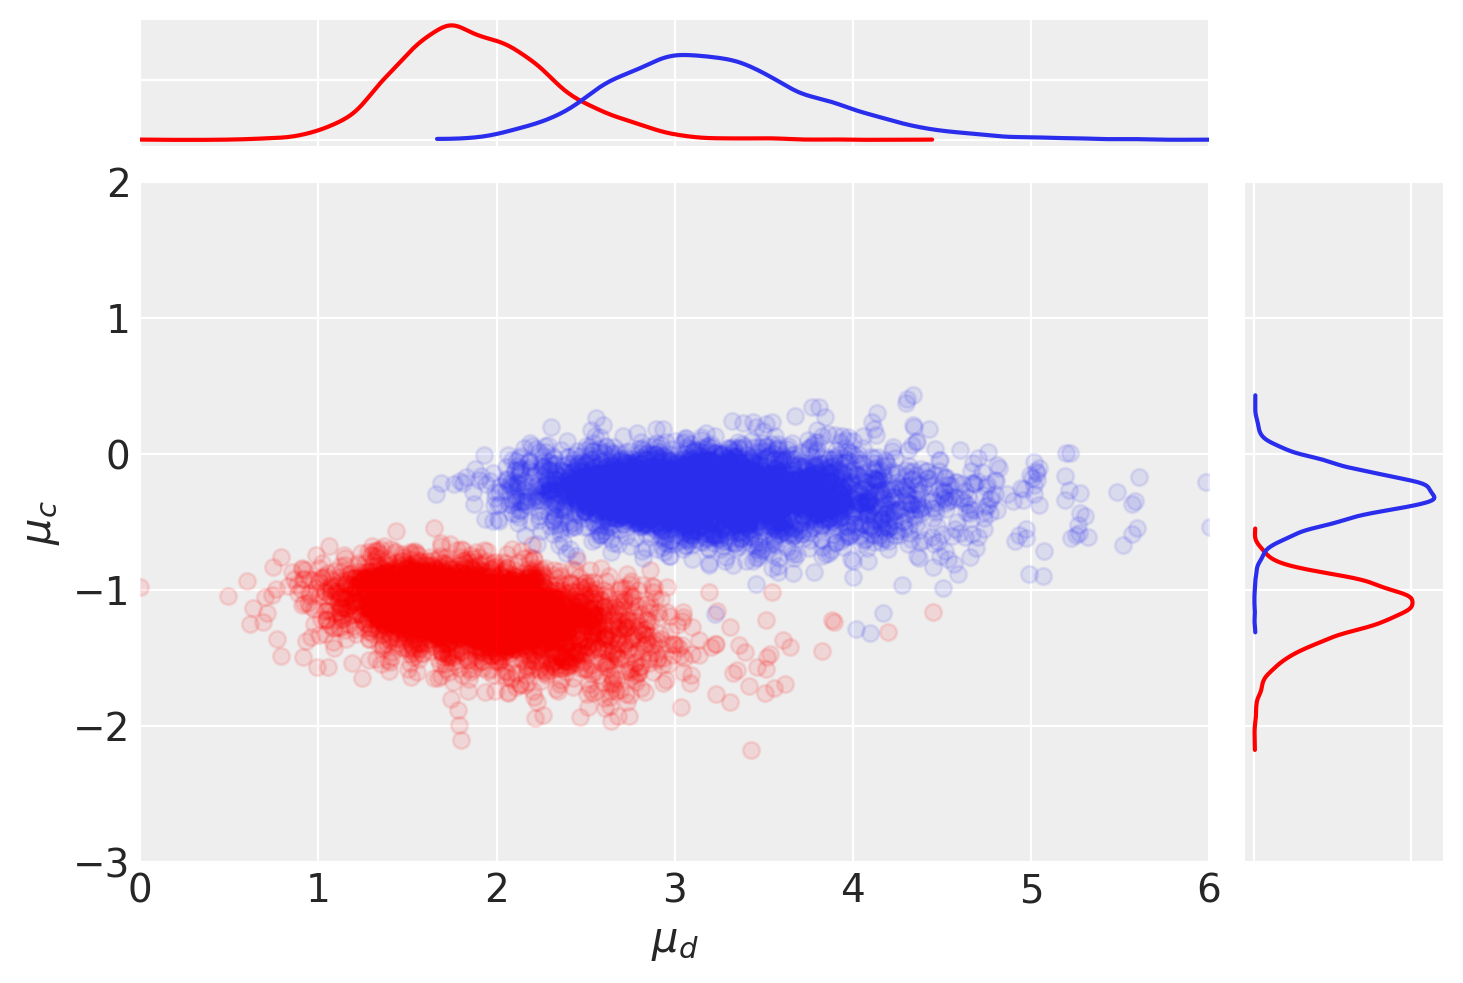

In [25]:
axes = az.plot_joint(trace_i3, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1, "color": "red"}, marginal_kwargs={"color": "r"})
az.plot_joint(trace_d3, var_names=["mud", "muc"], joint_kwargs={"alpha": 0.1}, ax=axes)
axes[0].set_xlim((0, 6))
axes[0].set_ylim((-3, 2))
axes[0].set_xlabel(r"$\mu_d$")
axes[0].set_ylabel(r"$\mu_c$");

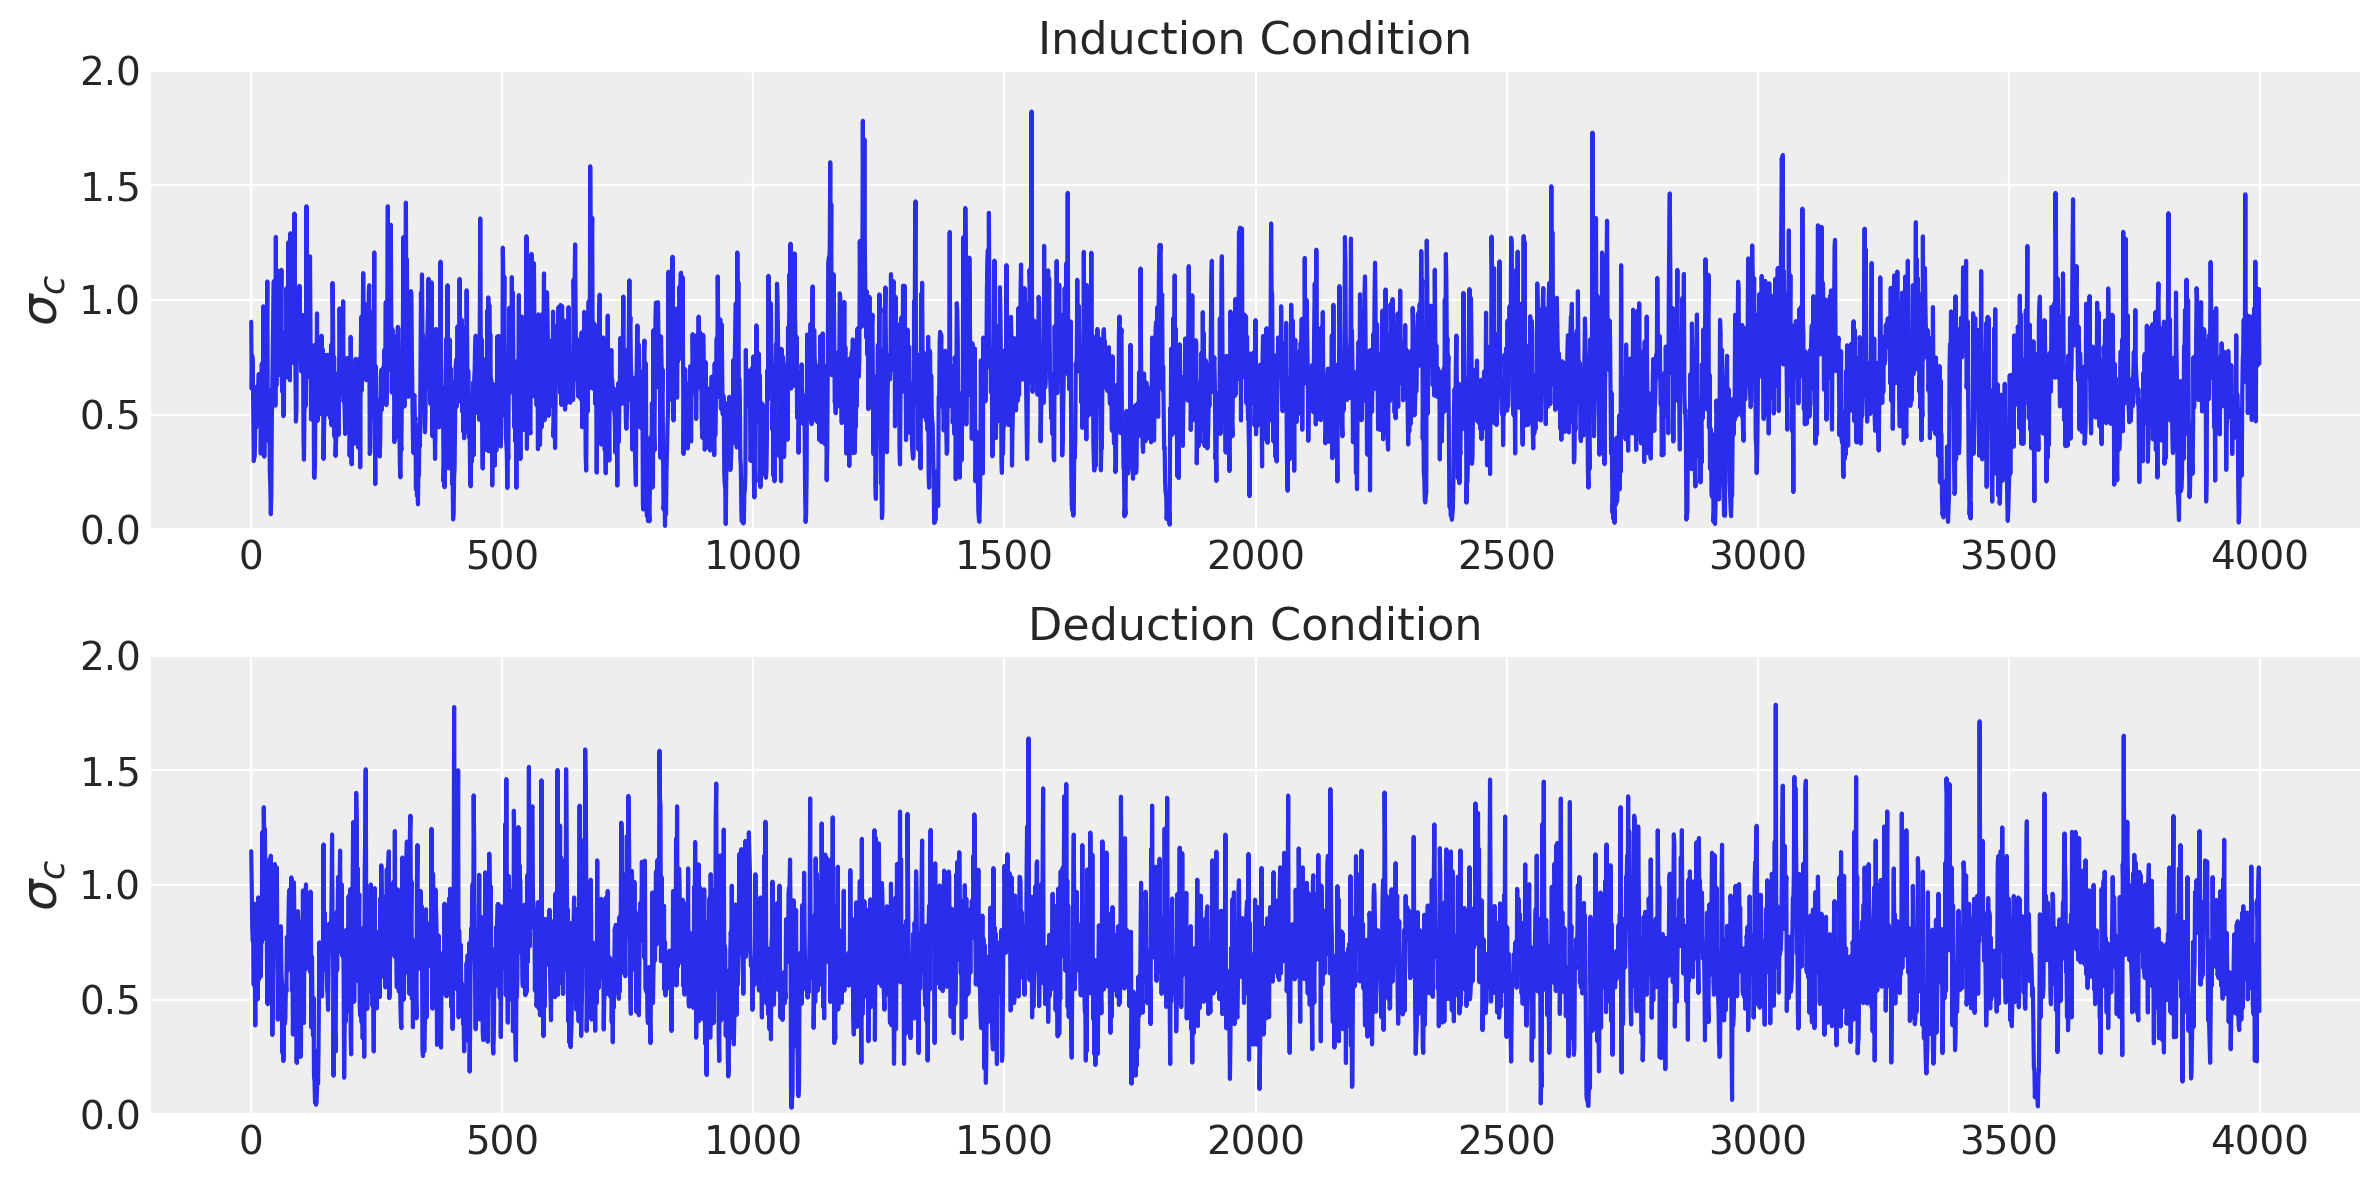

In [26]:
_, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(trace_i3["sigmac"])
ax[0].set_ylim(0, 2)
ax[0].set_title("Induction Condition")
ax[0].set_ylabel(r"$\sigma_c$", fontsize=18)

ax[1].plot(trace_d3["sigmac"])
ax[1].set_ylim(0, 2)
ax[1].set_title("Deduction Condition")
ax[1].set_ylabel(r"$\sigma_c$", fontsize=18)

plt.tight_layout();

The accept rate is: 0.98879
Divergences of the trace:
(array([], dtype=int64),)


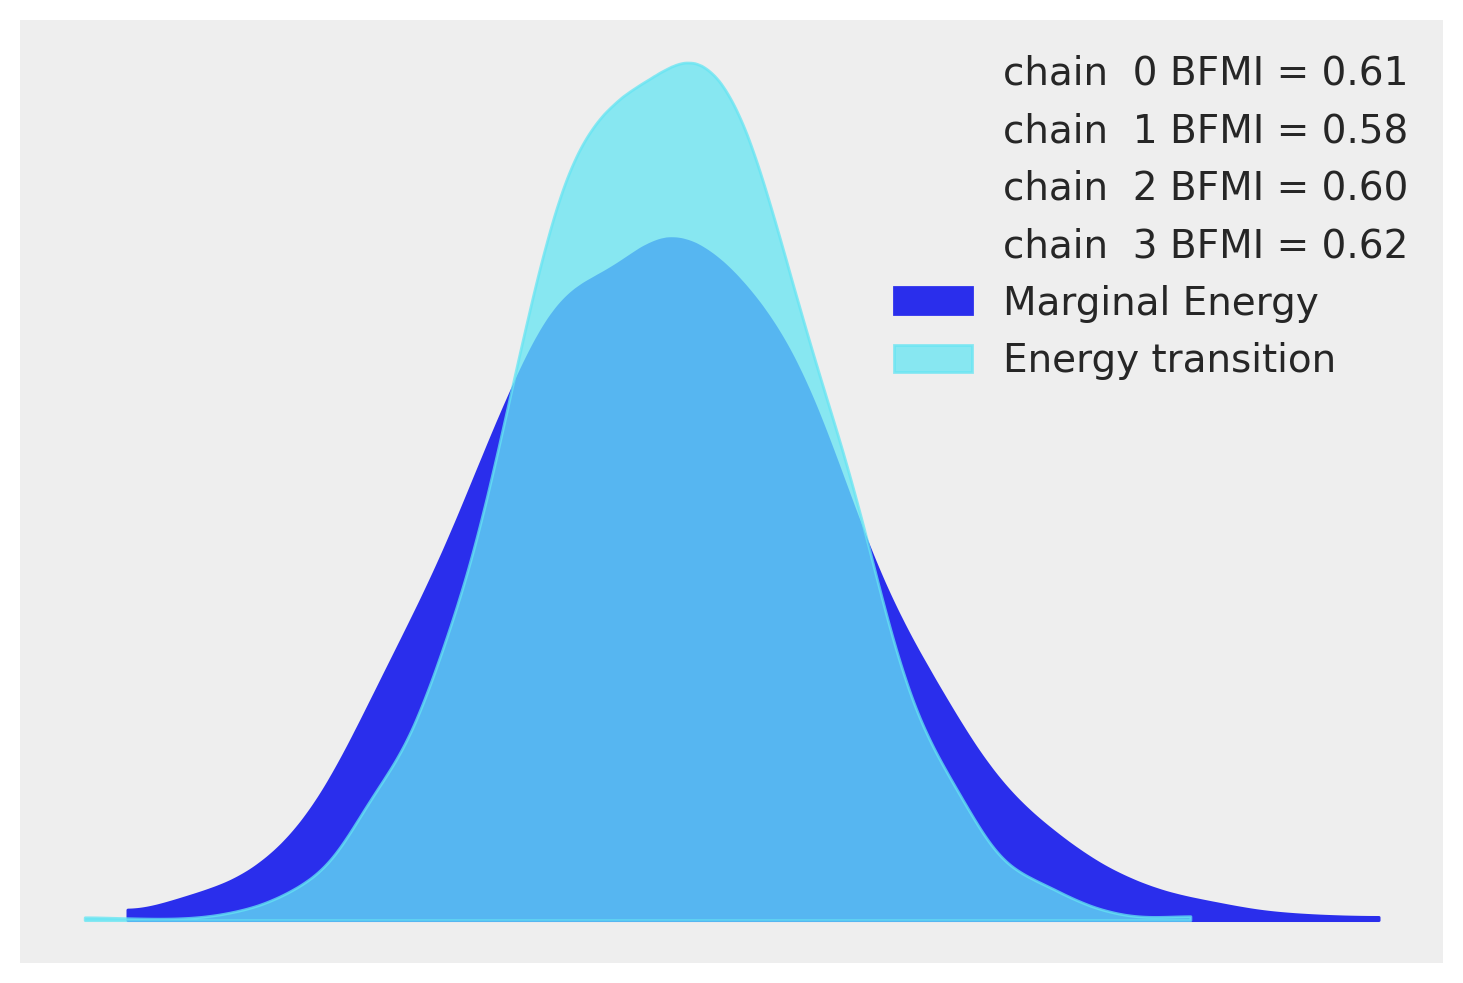

In [27]:
plot_samplerstat(trace_i3)

The accept rate is: 0.98919
Divergences of the trace:
(array([], dtype=int64),)


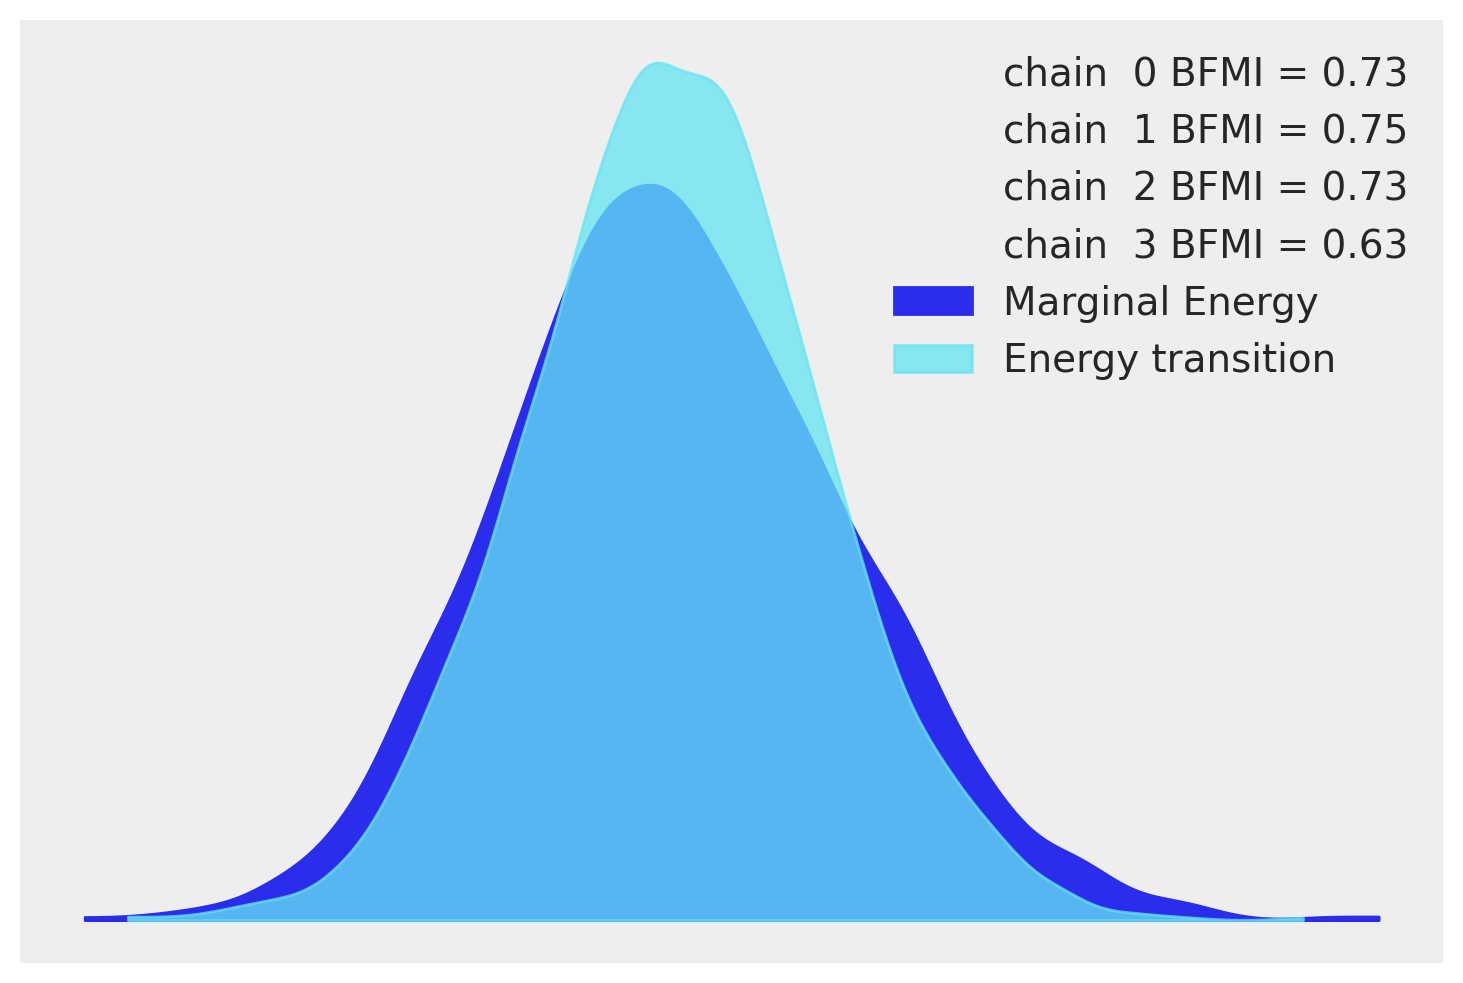

In [28]:
plot_samplerstat(trace_d3)

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.11.0
pymc   3.9.2
pandas  1.0.3
arviz   0.10.0
numpy   1.18.2
last updated: Mon Nov 23 2020 

CPython 3.8.5
IPython 7.13.0
watermark 2.0.2
